In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [57]:

def LSTM_pred(filename):
    # Load the dataset
    df = pd.read_csv('data/'+filename+'.csv')

    # Convert the dataframe to a numpy array
    dataset = df.values

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset[:, 2:])

    # Split into train and test sets
    train_size = int(len(dataset_scaled) * 0.95)
    test_size = len(dataset_scaled) - train_size
    train, test = dataset_scaled[0:train_size, :], dataset_scaled[train_size:len(dataset_scaled), :]

    # Convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 3]) # Assuming the 'close' column is the fourth column
        return np.array(dataX), np.array(dataY)

    look_back = 5
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

    # Create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam())
    model.fit(trainX, trainY, epochs=6, batch_size=1, verbose=2)

    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Reshape the data to match the input format of the scaler
    trainPredict_extended = np.zeros((len(trainPredict), train.shape[1]))
    testPredict_extended = np.zeros((len(testPredict), test.shape[1]))

    # Fill the predictions into the extended arrays and inverse transform
    trainPredict_extended[:, 3] = trainPredict[:, 0]  # Assuming 'close' is the 4th attribute
    testPredict_extended[:, 3] = testPredict[:, 0]    # Assuming 'close' is the 4th attribute

    trainPredict = scaler.inverse_transform(trainPredict_extended)[:, 3]
    testPredict = scaler.inverse_transform(testPredict_extended)[:, 3]

    # Because we used look_back, we must align the original testY values
    testY_actual = scaler.inverse_transform(test)[look_back:, 3]  # Align testY to the predictions

    # Calculate metrics
    testMAE = mean_absolute_error(testY_actual[:-1], testPredict)
    testRMSE = np.sqrt(mean_squared_error(testY_actual[:-1], testPredict))
    testR2 = r2_score(testY_actual[:-1], testPredict)

    # Print metrics
    print('Test MAE: %.3f' % testMAE)
    print('Test RMSE: %.3f' % testRMSE)
    print('Test R2: %.3f' % testR2)

    # Plot baseline and predictions
    plt.figure(figsize=(12,6))
    plt.plot(range(len(testY_actual)), testY_actual, label='Actual')
    plt.plot(range(len(testPredict)), testPredict, label='Predicted')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.savefig('RNN_'+filename+'.png')
    return testMAE, testRMSE, testR2

In [54]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

Epoch 1/6
10286/10286 - 16s - loss: 1.2651e-04 - 16s/epoch - 2ms/step
Epoch 2/6
10286/10286 - 16s - loss: 4.7840e-05 - 16s/epoch - 2ms/step
Epoch 3/6
10286/10286 - 16s - loss: 3.3042e-05 - 16s/epoch - 2ms/step
Epoch 4/6
10286/10286 - 15s - loss: 3.2033e-05 - 15s/epoch - 2ms/step
Epoch 5/6
10286/10286 - 16s - loss: 2.6772e-05 - 16s/epoch - 2ms/step
Epoch 6/6
10286/10286 - 17s - loss: 2.5601e-05 - 17s/epoch - 2ms/step
17/17 [==============================] - 0s 2ms/step
Test MAE: 4.195
Test RMSE: 5.096
Test R2: 0.904
Epoch 1/6
7644/7644 - 14s - loss: 4.8318e-04 - 14s/epoch - 2ms/step
Epoch 2/6
7644/7644 - 13s - loss: 2.2858e-04 - 13s/epoch - 2ms/step
Epoch 3/6
7644/7644 - 13s - loss: 2.0144e-04 - 13s/epoch - 2ms/step
Epoch 4/6
7644/7644 - 13s - loss: 1.9561e-04 - 13s/epoch - 2ms/step
Epoch 5/6
7644/7644 - 13s - loss: 1.8023e-04 - 13s/epoch - 2ms/step
Epoch 6/6
7644/7644 - 12s - loss: 1.7694e-04 - 12s/epoch - 2ms/step
13/13 [==============================] - 0s 2ms/step
Test MAE: 2.406
Te

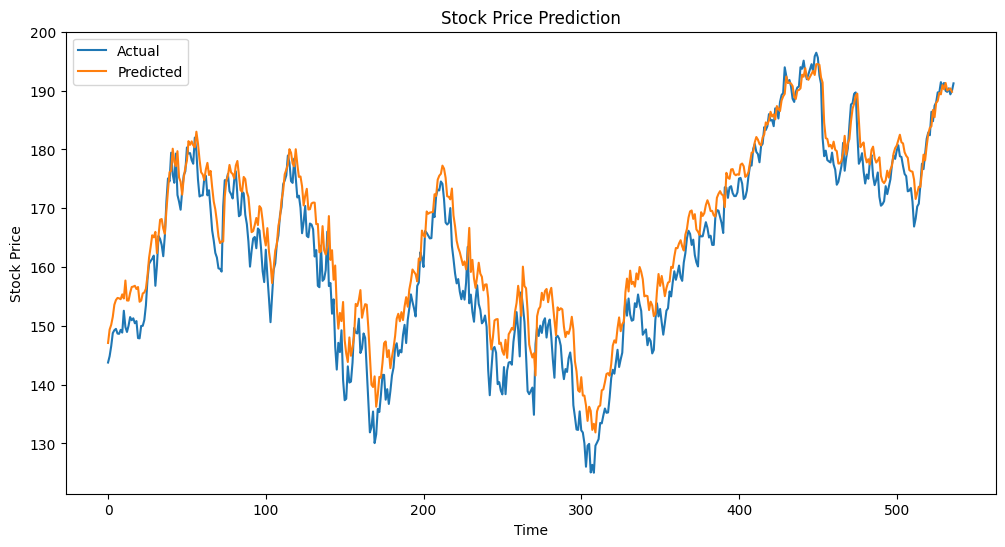

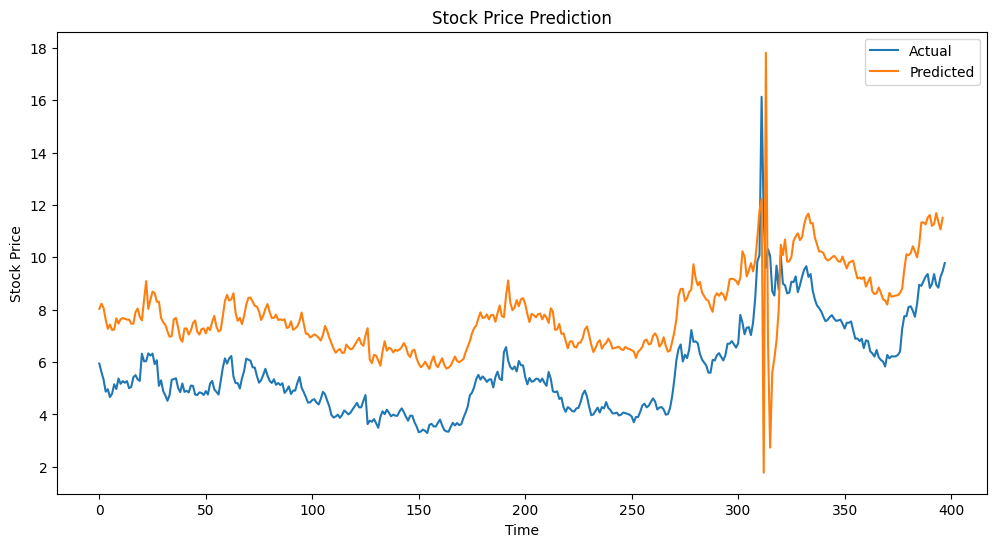

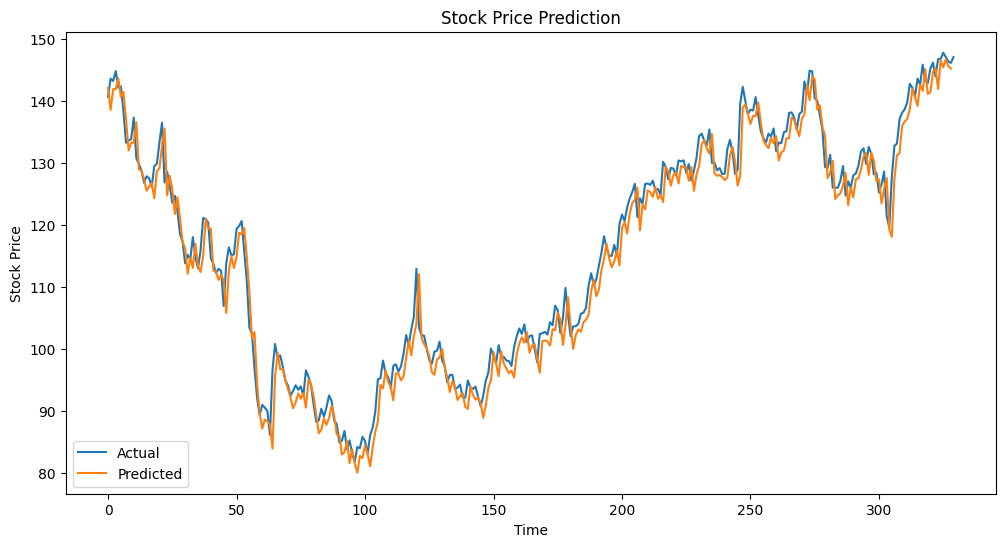

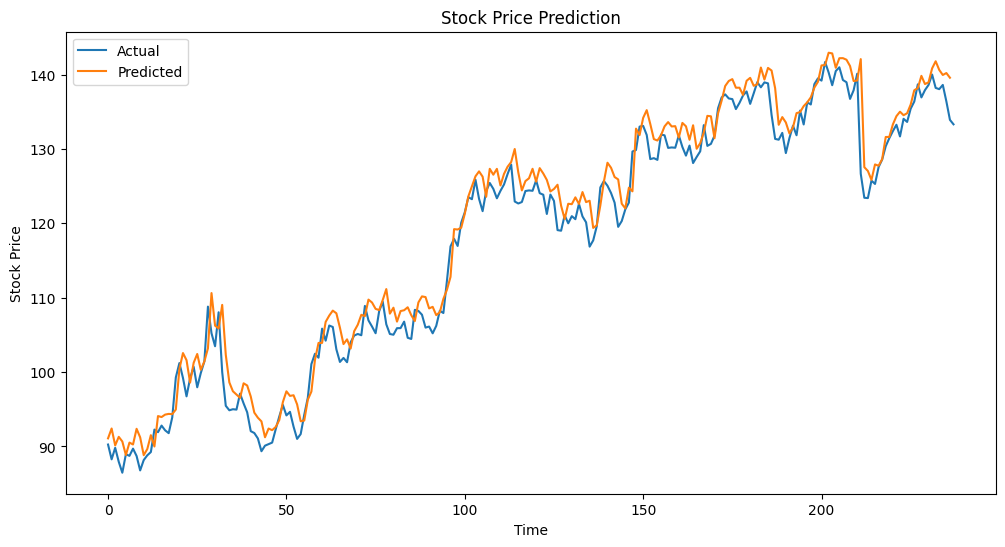

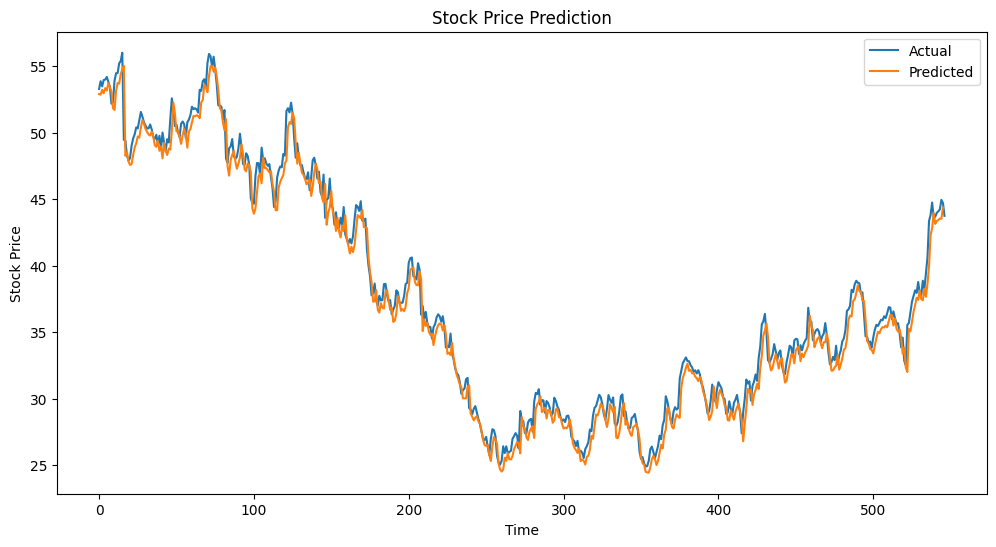

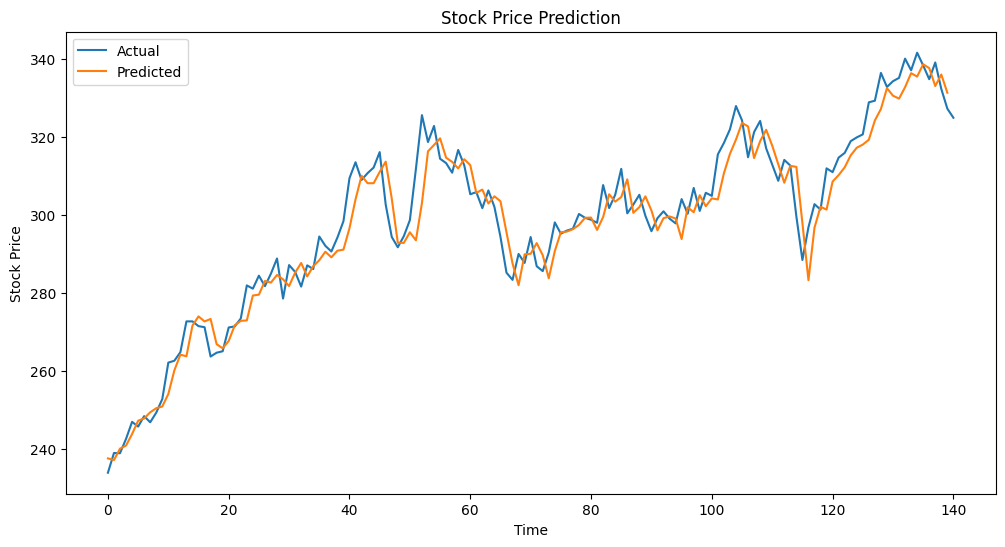

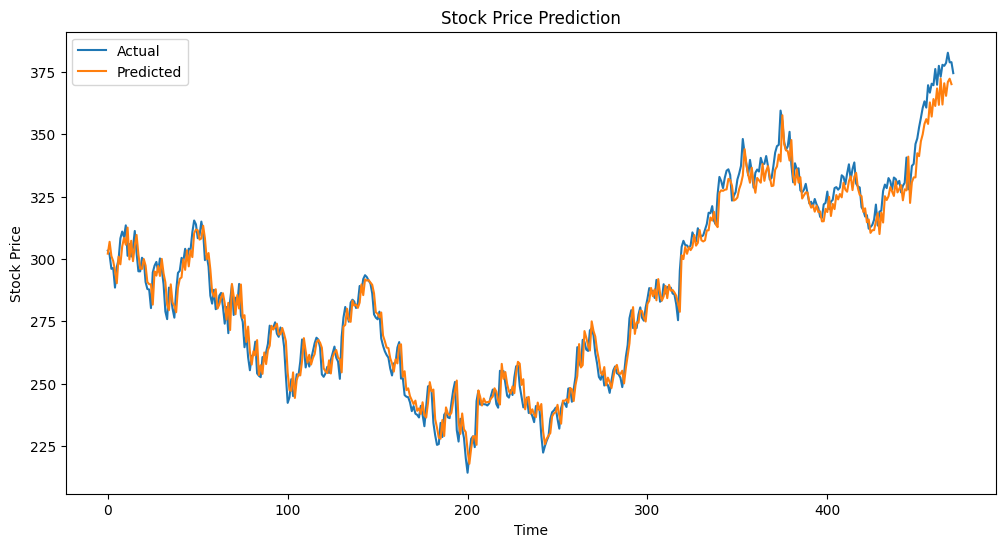

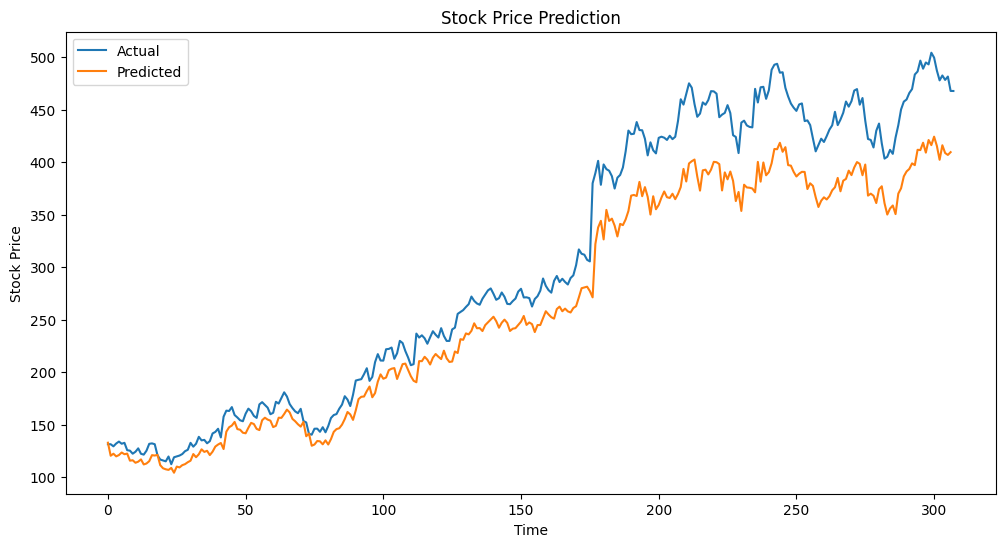

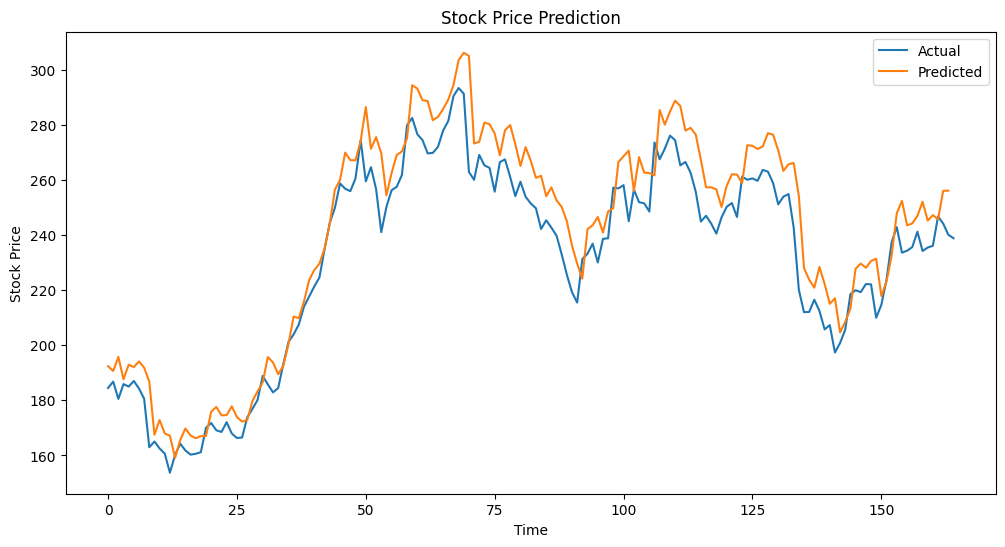

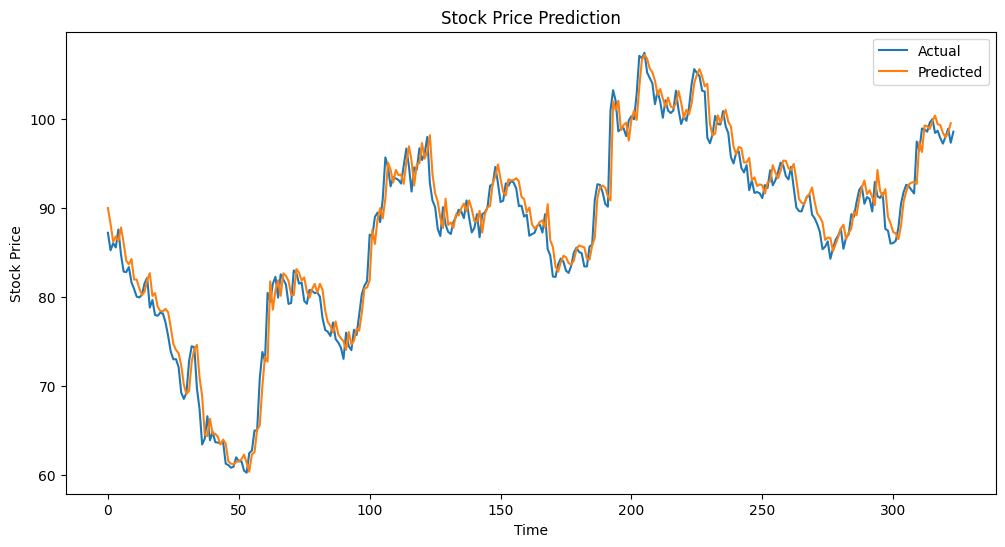

In [55]:
filenames = ['AAPL', 'AMSC', 'AMZN', 'GOOG', 'INTC', 'META', 'MSFT', 'NVDA', 'TSLA', 'TSM']
maes = []
rmses = []
r2s = []
for f in filenames[:]:
    x,y,z = LSTM_pred(f)
    maes.append(x)
    rmses.append(y)
    r2s.append(z)


In [58]:
print(np.array(maes).mean())
print(np.array(rmses).mean())
print(np.array([max(i,0) for i in r2s if i > 0]).mean())

7.081015476820907
8.610894439995095
0.940641474742739
